# <center> HAVOK
<center><img src="./Fig1.png" style="zoom:60%" />

# 0.导入需要的库

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.linear_model import Lasso, LinearRegression as LR
import seaborn as sns

plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.size'] = 14

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# 1. 绘制x图像

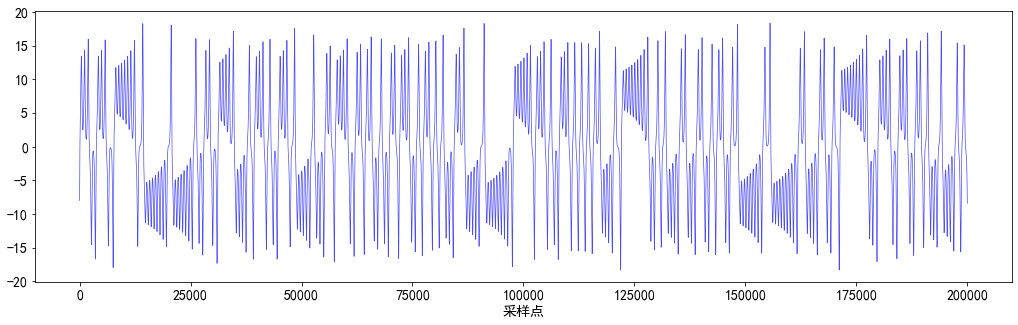

In [2]:
data = pd.read_csv('Lorenz.csv')
x = data['x1']    
plt.figure(figsize=(17.5, 5))
plt.xlabel('采样点')
plt.plot(x, linewidth=0.7, c='b', alpha=0.7);

# 2.奇异值分解

<font size=5>
$$ \mathbf{H}=\left[\begin{array}{cccc}
x\left(t_1\right) & x\left(t_2\right) & \cdots & x\left(t_p\right) \\
x\left(t_2\right) & x\left(t_3\right) & \cdots & x\left(t_{p+1}\right) \\
\vdots & \vdots & \ddots & \vdots \\
x\left(t_q\right) & x\left(t_{q+1}\right) & \cdots & x\left(t_m\right)
\end{array}\right]=\mathbf{U} \Sigma \mathbf{V}^* $$

In [3]:
### 求Hankel矩阵
q = 100
length = 20000    # 截取20000个点，不然内存不够计算
p = length - q
H = np.zeros((q, p))
for i in range(q):
    H[i, :] = x[i:i+p]

In [4]:
%%time
### 奇异值分解
r = 15
U, S, V = np.linalg.svd(H)
U = U[:, :r]
S = np.diag(S[:r])
V = V[:r, :]

CPU times: total: 3min 55s
Wall time: 39.6 s


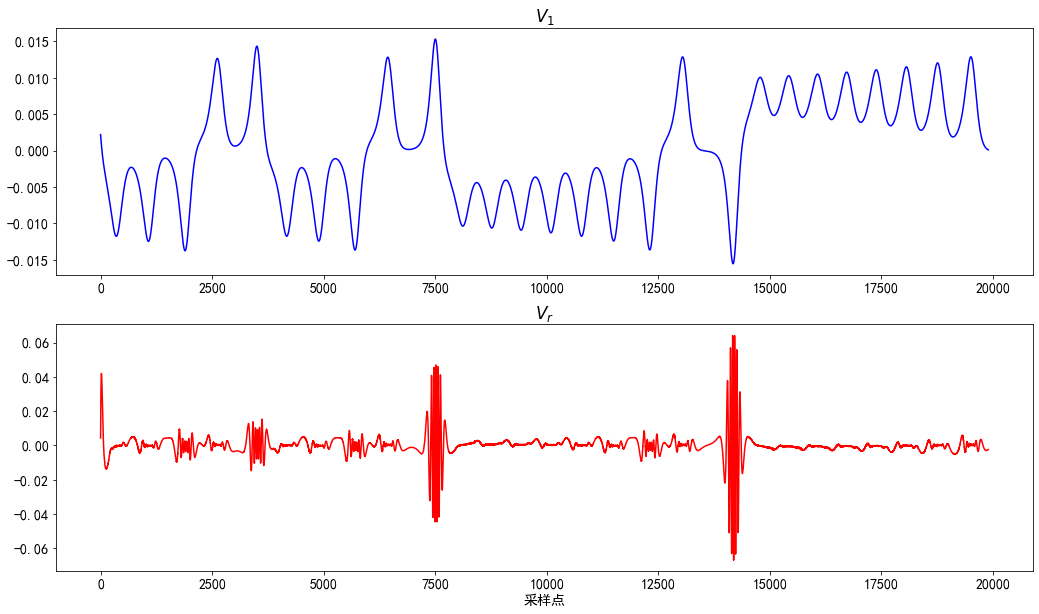

In [5]:
plt.figure(figsize=(17.5, 10))
plt.subplot(211)
plt.title('$V_{1}$')
plt.plot(V[0, :], c='b')
plt.subplot(212) 
plt.title('$V_{r}$')
plt.xlabel('采样点')
plt.plot(V[r-1, :], c='r');

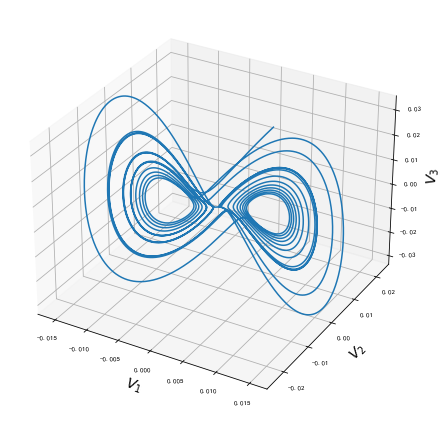

In [6]:
fig = plt.figure(figsize=(7.5, 7.5))
ax = plt.axes(projection='3d')
ax.set_xlabel('$V_1$')
ax.set_ylabel('$V_2$')
ax.set_zlabel('$V_3$')
ax.tick_params(labelsize=7)
ax.plot3D(V[0, :], V[1, :], V[2, :]);

# 3.回归

<font size=5><center>$$\frac{\mathrm{d}}{\mathrm{d} t} \mathbf{v}(t)=\mathbf{A} \mathbf{v}(t)+\mathbf{B} v_r(t)$$

<center><img src="./Fig2.png" style="zoom:80%" />

<font size=5><font size=5><center>Lasso回归：$$ Loss(w) = \sum_{i=1}^{n}(y_{i}-w^{T}x_{i})^{2} + \lambda \left\lVert w \right\rVert_{1} $$

In [7]:
### 计算dV，使用四阶中心差分
dV = np.zeros((r-1, V.shape[1]-5))
dt = 0.001
for i in range(2, V.shape[1]-3):
    for k in range(r-1):
        dV[k, i-2] = (1 / (12*dt)) * (-V[k, i+2] + 8*V[k, i+1] - 8*V[k, i-1] + V[k, i-2]);
x = V[:, 2:-3]
dx = dV

In [8]:
### 使用Lasso回归
W = np.zeros((r-1, r))
alpha = 1e-5    # 正则化系数
Xtrain = x
for n in range(dx.shape[0]):
    ytrain = dV[n, :]
    model = Lasso(alpha=alpha).fit(Xtrain.T, ytrain)
    W[n, :] = model.coef_

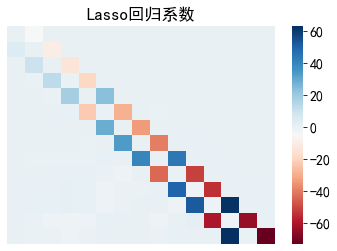

In [9]:
plt.title('Lasso回归系数')
sns.heatmap(W, cmap='RdBu', xticklabels=False, yticklabels=False);

# <center> Ho-Kalman

<font size=5>
$$ \mathbf{H}=\left[\begin{array}{cccc}
x\left(1\right) & x\left(2\right) & \cdots & x\left(p\right) \\
x\left(2\right) & x\left(3\right) & \cdots & x\left(p+1\right) \\
\vdots & \vdots & \ddots & \vdots \\
x\left(q\right) & x\left(q+1\right) & \cdots & x\left(m\right)
\end{array}\right]$$

<font size=5> 
$$ x(t+1)=\mathbf{A}x(t)+\mathbf{B}u(t) \\
y(t) = \mathbf{I}x(t)+\mathbf{0}u(t)$$

<font size=5> 
可推导出：$ \begin{aligned}y(t)=x(t) & =\mathbf{A}x(t-1)+\mathbf{B}u(t-1)=\mathbf{A}^{2}x(t-2)+\mathbf{AB}u(t-2)+\mathbf{B}u(t-1)=\cdots\\
    & = \mathbf{G}\overline{u}(t) + \mathbf{A}^{q-1}x(t-q+1)\end{aligned}$

<font size=5>其中：$ \mathbf{G} = [\mathbf{A}^{q-2}\mathbf{B},\mathbf{A}^{q-3}\mathbf{B}, \cdots,\mathbf{B}] $，$\overline{u}(t)=[u(t-q+1),u(t-q+2),\cdots,u(t-1)]^{T}$

<font size=5>令$ \mathbf{U}=\left[\begin{array}{cccc}
u\left(1\right) & u\left(2\right) & \cdots & u\left(p\right) \\
u\left(2\right) & u\left(3\right) & \cdots & u\left(p+1\right) \\
\vdots & \vdots & \ddots & \vdots \\
u\left(q-1\right) & u\left(q\right) & \cdots & u\left(m-1\right)
\end{array}\right]$，$\mathbf{y}=\mathbf{H}[-1,\ :]$，则$\hat{\mathbf{G}}=\underset{\mathbf{X}\in\mathbb{R}^{q}}{\arg \min } \left\|\mathbf{y}- \mathbf{U}\mathbf{X}\right\|_{2}^2$

<font size=5>解得：$\hat{\mathbf{G}}=\mathbf{U}^{\dagger}\mathbf{y}=(\mathbf{U}^{T}\mathbf{U})^{-1}\mathbf{U}^{T}\mathbf{y}$

In [10]:
### 构造输入输出矩阵
x = data['x1']    
u = data['x2']
q = 100
length = 20000    
p = length - q
y = x[q-1:q-1+p]
U = np.zeros((q-1, p))
for i in range(q-1):
    U[i, :] = u[i:i+p]

In [11]:
### 回归拟合
model = LR().fit(U.T, y)
G_hat = model.coef_

In [12]:
### 预测后20000个点
len_hat = 20000
y_hat = np.zeros(len_hat)
for i in range(len_hat):
    u_temp = u[i+p-q: i+p-1]
    y_hat[i] = G_hat.dot(u_temp)

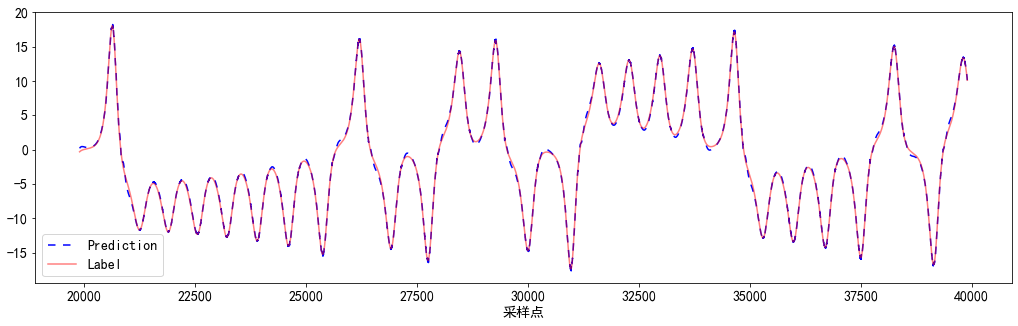

In [13]:
plt.figure(figsize=(17.5, 5))
t = [*range(p, p + len_hat)]
plt.plot(t, y_hat, 'b--', dashes=(5, 5), label='Prediction')
plt.plot(t, x[p:p+len_hat], 'r-', alpha=0.5, label='Label')
plt.xlabel('采样点')
plt.legend();